In [19]:
# @title Install dependencies
!pip install Pillow --quiet
!pip install torch_intermediate_layer_getter --quiet


In [20]:
#  Imports
import copy

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter

from torchvision import transforms
import torchvision.models as models


from scipy.spatial.distance import pdist
from scipy.stats import pearsonr

In [21]:
# @title Downloading Kay dataset
import requests

fnames = ["kay_labels.npy", "kay_labels_val.npy", "kay_images.npz"]

urls =['https://osf.io/r638s/download',
       'https://osf.io/yqb3e/download',
       'https://osf.io/ymnjv/download']

for i, url in enumerate(urls):
  r = requests.get(url, allow_redirects=True)
  with open(fnames[i], 'wb') as fh:
    fh.write(r.content)


with np.load(fnames[2]) as dobj:
  dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')

In [22]:
# @title Setting up training and test data for LOC region
final_response_tr = np.zeros((1750, 8428))
final_response_ts = np.zeros((120, 8428))

ctr = 0
for i in range(1,8):
  loc_id = np.where(dat['roi'] == i)
  response_tr = np.squeeze(dat["responses"][:, loc_id])
  response_ts = np.squeeze(dat["responses_test"][:, loc_id])

  final_response_tr[:, ctr:ctr+response_tr.shape[1]] = response_tr
  final_response_ts[:, ctr:ctr+response_ts.shape[1]] = response_ts

  ctr+=response_tr.shape[1]

In [23]:
response_tr = final_response_tr
response_ts = final_response_ts

# Adversarial Policy Gradient 

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Define the Policy Network
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(PolicyNetwork, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, output_size)


    
    def forward(self, state):
        logits = self.fc4(self.fc3(self.fc2(self.fc1(state))))
        return F.softmax(logits, dim=-1)

# Define the Reward Network
class RewardNetwork(nn.Module):
    def __init__(self, input_size):
        super(RewardNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
    
    def forward(self, state):
        return self.fc3(self.fc2(self.fc1(state)))

# Define the Adversarial Policy Gradient algorithm
class AdversarialPolicyGradient:
    def __init__(self, input_size, output_size, learning_rate, beta):
        self.policy_network = PolicyNetwork(input_size, output_size)
        self.reward_network = RewardNetwork(input_size)
        self.policy_optimizer = optim.Adam(self.policy_network.parameters(), lr=learning_rate)
        self.reward_optimizer = optim.Adam(self.reward_network.parameters(), lr=learning_rate)
        self.beta = beta
    
    def update_policy_network(self, states, actions, rewards):
        self.policy_optimizer.zero_grad()
        
        log_probs = torch.log(self.policy_network(states))
        selected_log_probs = torch.gather(log_probs, 1, actions.view(-1, 1))
        policy_loss = -(selected_log_probs * rewards).mean()
        
        policy_loss.backward()
        self.policy_optimizer.step()
    
    def update_reward_network(self, states, actual_rewards):
        self.reward_optimizer.zero_grad()
        
        predicted_rewards = self.reward_network(states)
        reward_loss = F.mse_loss(predicted_rewards, actual_rewards)
        
        reward_loss.backward()
        self.reward_optimizer.step()
    
    def adversarial_policy_gradient(self, states, actions, actual_rewards):
        self.update_reward_network(states, actual_rewards)
        self.update_policy_network(states, actions, actual_rewards)
    
    def train(self, train_states, train_actions, train_rewards, num_episodes):
        train_dataset = TensorDataset(train_states, train_actions, train_rewards)
        train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        
        for episode in range(num_episodes):
            for states, actions, rewards in train_dataloader:
                self.adversarial_policy_gradient(states, actions, rewards)
    
    def test(self, test_states, test_actions):
        with torch.no_grad():
            policy_probs = self.policy_network(test_states)
            predicted_rewards = self.reward_network(test_states)
            return policy_probs, predicted_rewards

# Dummy inputs and outputs
input_size = 8428
output_size = 21


train_states = torch.from_numpy(response_tr).to(torch.float32)
train_actions = torch.randint(output_size, (1750,))
train_rewards = torch.randn(1750, 1)

print(train_states.dtype)
test_states = torch.from_numpy(response_ts).to(torch.float32)
test_actions = torch.randint(output_size, (120,))





torch.float32


# HyperParameter Tuning

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm


In [26]:
Y_tr  = labels[0]
Y_ts = val_labels[0]

In [27]:
learning_rate = 0.000005
beta = 0.1
num_episodes = 15

result_ep = np.zeros((16,6))

for i in range(1,15):
  num_episodes = i
# Model training and testing
  adversarial_pg = AdversarialPolicyGradient(input_size, output_size, learning_rate, beta)
  adversarial_pg.train(train_states, train_actions, train_rewards, num_episodes)
  policy_probs, predicted_rewards = adversarial_pg.test(test_states, test_actions)


  policy_prob_tr , _ = adversarial_pg.test(train_states, train_actions)

  X_tr = policy_prob_tr
  X_ts = policy_probs

  from sklearn import svm
  clf = svm.SVC(gamma='scale')
  clf.fit(X_tr, Y_tr)  

  result_ep[i, 0] = (((clf.predict(X_ts) == Y_ts).sum())/120)*100

  gnb = GaussianNB()
  nb = gnb.fit(X_tr, Y_tr)

  result_ep[i, 1] = (((nb.predict(X_ts) == Y_ts).sum())/120)*100

  clf = LinearDiscriminantAnalysis()
  clf.fit(X_tr, Y_tr)  

  result_ep[i, 2] = (((clf.predict(X_ts) == Y_ts).sum())/120)*100

  knn = KNeighborsClassifier()
  knn.fit(X_tr, Y_tr) 
  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=None, n_neighbors=5, p=2,
            weights='uniform')

  result_ep[i,3] = (((knn.predict(X_ts) == Y_ts).sum())/120)*100

  clf = tree.DecisionTreeClassifier()
  clf = clf.fit(X_tr, Y_tr)

  result_ep[i,4] = (((clf.predict(X_ts) == Y_ts).sum())/120)*100

  ada = AdaBoostClassifier(n_estimators =100)
  ada.fit(X_tr,Y_tr)

  result_ep[i,5] = (((ada.predict(X_ts) == Y_ts).sum())/120)*100


  print(result_ep[i])

[41.66666667 39.16666667 42.5        48.33333333 31.66666667 41.66666667]
[42.5        40.         43.33333333 40.         34.16666667 41.66666667]
[42.5        27.5        45.         43.33333333 43.33333333 41.66666667]
[42.5        37.5        41.66666667 41.66666667 39.16666667 40.83333333]
[41.66666667 30.83333333 41.66666667 35.         36.66666667 41.66666667]
[41.66666667 35.         41.66666667 41.66666667 30.83333333 41.66666667]
[39.16666667 29.16666667 41.66666667 35.83333333 30.         40.83333333]
[41.66666667 27.5        41.66666667 36.66666667 44.16666667 45.        ]
[37.5        22.5        40.83333333 40.         29.16666667 36.66666667]
[40.         24.16666667 41.66666667 42.5        34.16666667 41.66666667]
[37.5        24.16666667 40.83333333 35.         42.5        36.66666667]
[41.66666667 27.5        39.16666667 45.         37.5        24.16666667]
[41.66666667 30.         41.66666667 40.83333333 35.         29.16666667]
[41.66666667 27.5        40.83333333 4

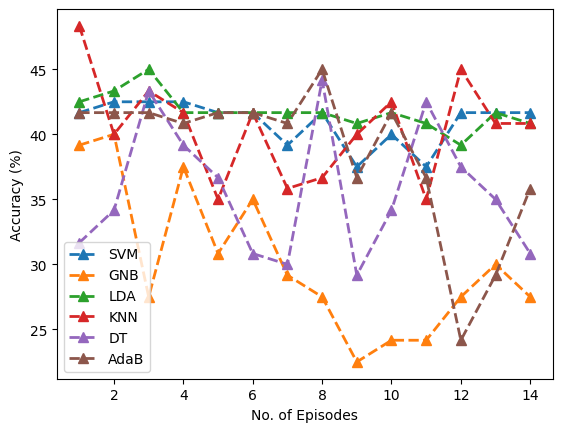

In [28]:
from matplotlib import pyplot as plt

name = ['SVM', 'GNB', 'LDA', 'KNN' , 'DT', 'AdaB']

for i in range(6):
  plt.plot(range(1,15), result_ep[1:-1, i], linestyle='dashed', linewidth = 2,
         marker='^', markersize=7, label = name[i])


plt.xlabel('No. of Episodes')
plt.ylabel('Accuracy (%)')

plt.legend()

plt.savefig('3layer_ep.pdf')

plt.show()


In [29]:
learning_rate = 0.000005
beta = 0.1
num_episodes = 5

result_b = np.zeros((10,6))

for i in range(1,10, 1):
  beta = i * 0.1
# Model training and testing
  adversarial_pg = AdversarialPolicyGradient(input_size, output_size, learning_rate, beta)
  adversarial_pg.train(train_states, train_actions, train_rewards, num_episodes)
  policy_probs, predicted_rewards = adversarial_pg.test(test_states, test_actions)


  policy_prob_tr , _ = adversarial_pg.test(train_states, train_actions)

  X_tr = policy_prob_tr
  X_ts = policy_probs

  from sklearn import svm
  clf = svm.SVC(gamma='scale')
  clf.fit(X_tr, Y_tr)  

  result_b[i, 0] = (((clf.predict(X_ts) == Y_ts).sum())/120)*100

  gnb = GaussianNB()
  nb = gnb.fit(X_tr, Y_tr)

  result_b[i, 1] = (((nb.predict(X_ts) == Y_ts).sum())/120)*100

  clf = LinearDiscriminantAnalysis()
  clf.fit(X_tr, Y_tr)  

  result_b[i, 2] = (((clf.predict(X_ts) == Y_ts).sum())/120)*100

  knn = KNeighborsClassifier()
  knn.fit(X_tr, Y_tr) 
  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=None, n_neighbors=5, p=2,
            weights='uniform')

  result_b[i,3] = (((knn.predict(X_ts) == Y_ts).sum())/120)*100

  clf = tree.DecisionTreeClassifier()
  clf = clf.fit(X_tr, Y_tr)

  result_b[i,4] = (((clf.predict(X_ts) == Y_ts).sum())/120)*100

  ada = AdaBoostClassifier(n_estimators =100)
  ada.fit(X_tr,Y_tr)

  result_b[i,5] = (((ada.predict(X_ts) == Y_ts).sum())/120)*100


  print(result_b[i])

[40.         31.66666667 40.83333333 45.83333333 35.83333333 41.66666667]
[38.33333333 30.83333333 40.         44.16666667 28.33333333 10.83333333]
[41.66666667 30.83333333 42.5        49.16666667 40.         40.83333333]
[41.66666667 26.66666667 41.66666667 32.5        33.33333333 27.5       ]
[39.16666667 26.66666667 40.83333333 35.         34.16666667 10.        ]
[40.         30.         41.66666667 40.         37.5        40.83333333]
[41.66666667 28.33333333 41.66666667 36.66666667 35.         41.66666667]
[42.5        31.66666667 41.66666667 44.16666667 33.33333333 41.66666667]
[41.66666667 33.33333333 41.66666667 38.33333333 30.83333333 41.66666667]


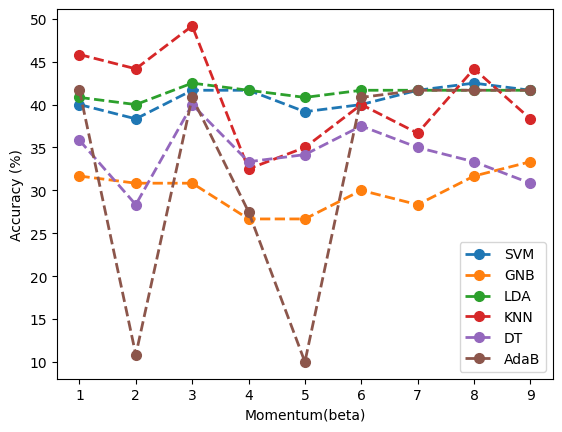

In [30]:
from matplotlib import pyplot as plt

name = ['SVM', 'GNB', 'LDA', 'KNN' , 'DT', 'AdaB']

for i in range(6):
  plt.plot(range(1,10), result_b[1:, i], linestyle='dashed', linewidth = 2,
         marker='o', markersize=7, label = name[i])


plt.xlabel('Momentum(beta)')
plt.ylabel('Accuracy (%)')

plt.legend()

plt.savefig('3layer_b.pdf')

plt.show()

In [31]:
# learning_rate = 0.000005
# beta = 0.1
# num_episodes = 2

# result_lr = np.zeros((9,6))

# for i in [0.00005,0.00001, 0.000005, 0.000001]:
#   learning_rate = i
# # Model training and testing
#   adversarial_pg = AdversarialPolicyGradient(input_size, output_size, learning_rate, beta)
#   adversarial_pg.train(train_states, train_actions, train_rewards, num_episodes)
#   policy_probs, predicted_rewards = adversarial_pg.test(test_states, test_actions)


#   policy_prob_tr , _ = adversarial_pg.test(train_states, train_actions)

#   X_tr = policy_prob_tr
#   X_ts = policy_probs

#   from sklearn import svm
#   clf = svm.SVC(gamma='scale')
#   clf.fit(X_tr, Y_tr)  

#   result_lr[i, 0] = (((clf.predict(X_ts) == Y_ts).sum())/120)*100

#   gnb = GaussianNB()
#   nb = gnb.fit(X_tr, Y_tr)

#   result_lr[i, 1] = (((nb.predict(X_ts) == Y_ts).sum())/120)*100

#   clf = LinearDiscriminantAnalysis()
#   clf.fit(X_tr, Y_tr)  

#   result_lr[i, 2] = (((clf.predict(X_ts) == Y_ts).sum())/120)*100

#   knn = KNeighborsClassifier()
#   knn.fit(X_tr, Y_tr) 
#   KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
#             metric_params=None, n_jobs=None, n_neighbors=5, p=2,
#             weights='uniform')

#   result_lr[i,3] = (((knn.predict(X_ts) == Y_ts).sum())/120)*100

#   clf = tree.DecisionTreeClassifier()
#   clf = clf.fit(X_tr, Y_tr)

#   result_lr[i,4] = (((clf.predict(X_ts) == Y_ts).sum())/120)*100

#   ada = AdaBoostClassifier(n_estimators =100)
#   ada.fit(X_tr,Y_tr)

#   result_lr[i,5] = (((ada.predict(X_ts) == Y_ts).sum())/120)*100


#   print(result_lr[i])

In [32]:
learning_rate = 0.000001
beta = 0.1
num_episodes = 5

result = np.zeros((8, 6))


i = 0

# Model training and testing
adversarial_pg = AdversarialPolicyGradient(input_size, output_size, learning_rate, beta)
adversarial_pg.train(train_states, train_actions, train_rewards, num_episodes)
policy_probs, predicted_rewards = adversarial_pg.test(test_states, test_actions)


policy_prob_tr , _ = adversarial_pg.test(train_states, train_actions)

X_tr = policy_prob_tr
X_ts = policy_probs

clf = svm.SVC(gamma='scale')
clf.fit(X_tr, Y_tr)  

result[i, 0] = (((clf.predict(X_ts) == Y_ts).sum())/120)*100

gnb = GaussianNB()
nb = gnb.fit(X_tr, Y_tr)

result[0, 1] = (((nb.predict(X_ts) == Y_ts).sum())/120)*100

clf = LinearDiscriminantAnalysis()
clf.fit(X_tr, Y_tr)  

result[0, 2] = (((clf.predict(X_ts) == Y_ts).sum())/120)*100

knn = KNeighborsClassifier()
knn.fit(X_tr, Y_tr) 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

result[0,3] = (((knn.predict(X_ts) == Y_ts).sum())/120)*100

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_tr, Y_tr)

result[0,4] = (((clf.predict(X_ts) == Y_ts).sum())/120)*100

ada = AdaBoostClassifier(n_estimators =100)
ada.fit(X_tr,Y_tr)

result[0,5] = (((ada.predict(X_ts) == Y_ts).sum())/120)*100


print(result[0])

[41.66666667 40.         42.5        39.16666667 40.         41.66666667]


In [33]:
policy_prob_tr , _ = adversarial_pg.test(train_states, train_actions)
Y_tr  = labels[0]

X_ts = policy_probs
Y_ts = val_labels[0]

In [34]:
print(policy_prob_tr.shape)
print(response_tr.shape)
print(Y_tr.shape)

torch.Size([1750, 21])
(1750, 8428)
(1750,)


In [35]:
# result = np.zeros((8, 6))
for i in range(1,8):
  # @title Setting up training and test data for LOC region
  loc_id = np.where(dat['roi'] == i)
  response_tr = np.squeeze(dat["responses"][:, loc_id])
  response_ts = np.squeeze(dat["responses_test"][:, loc_id])

  X_tr = response_tr
  X_ts = response_ts


  from sklearn import svm
  clf = svm.SVC(gamma='scale')
  clf.fit(X_tr, Y_tr)  

  result[i, 0] = (((clf.predict(X_ts) == Y_ts).sum())/120)*100

  gnb = GaussianNB()
  nb = gnb.fit(X_tr, Y_tr)

  result[i, 1] = (((nb.predict(X_ts) == Y_ts).sum())/120)*100

  clf = LinearDiscriminantAnalysis()
  clf.fit(X_tr, Y_tr)  

  result[i, 2] = (((clf.predict(X_ts) == Y_ts).sum())/120)*100

  knn = KNeighborsClassifier()
  knn.fit(X_tr, Y_tr) 
  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=None, n_neighbors=5, p=2,
            weights='uniform')

  result[i,3] = (((knn.predict(X_ts) == Y_ts).sum())/120)*100

  clf = tree.DecisionTreeClassifier()
  clf = clf.fit(X_tr, Y_tr)

  result[i,4] = (((clf.predict(X_ts) == Y_ts).sum())/120)*100

  ada = AdaBoostClassifier(n_estimators =100)
  ada.fit(X_tr,Y_tr)

  result[i,5] = (((ada.predict(X_ts) == Y_ts).sum())/120)*100

In [36]:
print(result)

[[41.66666667 40.         42.5        39.16666667 40.         41.66666667]
 [44.16666667  7.5        43.33333333 40.83333333 40.         41.66666667]
 [44.16666667  5.83333333 30.         46.66666667 39.16666667 41.66666667]
 [48.33333333  7.5        16.66666667 43.33333333 43.33333333 41.66666667]
 [50.83333333  7.5        51.66666667 43.33333333 51.66666667 41.66666667]
 [50.         11.66666667 52.5        45.83333333 40.         47.5       ]
 [50.83333333  6.66666667 35.83333333 45.         48.33333333 41.66666667]
 [54.16666667  8.33333333 45.83333333 45.         50.         49.16666667]]
